In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Bidirectional

In [2]:
ppc_df = pd.read_csv('hybe_04.SentimentWord_01.csv') 
stock_df = pd.read_csv('../data/stock/hybe_stock_data.csv') # 주가 df

In [3]:
# Label 컬럼 생성: 다음 날 주가가 오늘보다 높으면 1, 그렇지 않으면 0
stock_df['Label'] = (stock_df['Close'].shift(-1) > stock_df['Close']).astype(int)
stock_df = stock_df[['Date', 'Label']]

# 필요한 컬럼만 빼서 다시 정의
ppc_df = ppc_df[['Date', 'ppc_Title', 'Tokens', 'Score']]

# 'Date' 컬럼을 기준으로 두 DataFrame을 합치기
df = pd.merge(ppc_df, stock_df, on='Date')

----

In [4]:
# 데이터를 훈련 세트와 테스트 세트로 분할 8:2
X_train, X_test, y_train, y_test = train_test_split(df['Tokens'], df['Label'], test_size=0.2, random_state=42)

In [5]:
# identity_tokenizer 함수 정의: 이미 토큰화된 데이터를 입력으로 받아 그대로 반환하는 함수
# 이 함수는 TfidfVectorizer의 tokenizer 파라미터에 사용될 것
def identity_tokenizer(text):
    return text

# TfidfVectorizer의 인스턴스를 생성
# tokenizer 파라미터에 identity_tokenizer를 지정하여 이미 토큰화된 데이터를 그대로 사용
# lowercase=False 옵션은 데이터가 이미 토큰화된 상태이므로 대소문자 변환을 비활성화
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)

# 학습 데이터를 TF-IDF 벡터로 변환 fit_transform 메서드는 단어 사전을 학습하고
# 데이터를 해당 TF-IDF 벡터로 변환
X_train_tfidf = tfidf.fit_transform(X_train)

# 테스트 데이터를 동일한 단어 사전을 사용하여 TF-IDF 벡터로 변환
# transform 메서드는 이미 학습된 단어 사전을 기반으로 데이터를 벡터로 변환
X_test_tfidf = tfidf.transform(X_test)

# Logistic Regression 모델을 생성하고 학습 데이터에 대해 학습을 수행
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# 테스트 데이터에 대해 예측을 수행
y_pred = model.predict(X_test_tfidf)

# 정확도를 계산 accuracy_score 함수는 실제 레이블과 예측 레이블을 비교하여 정확도를 산출
accuracy = accuracy_score(y_test, y_pred)

# 정확도를 소수점 셋째 자리까지 출력
print("정확도: {:.3f}".format(accuracy))

# 분류 보고서를 출력 classification_report는 각 클래스에 대한 정밀도, 재현율, f1-스코어를 제공
# 이는 모델의 성능을 다각도로 평가하는 데 유용
print("분류 보고서:\n", classification_report(y_test, y_pred))

c:\Users\sinji\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


정확도: 0.563
분류 보고서:
               precision    recall  f1-score   support

           0       0.58      0.82      0.68      1052
           1       0.48      0.22      0.30       786

    accuracy                           0.56      1838
   macro avg       0.53      0.52      0.49      1838
weighted avg       0.54      0.56      0.52      1838



----

In [6]:
# 텍스트를 정수 시퀀스로 변환하기 위한 Tokenizer 초기화
tokenizer = Tokenizer()

# 학습 데이터로 Tokenizer 학습
# 이 과정에서 Tokenizer는 학습 데이터에 등장하는 모든 단어에 고유한 정수를 할당
tokenizer.fit_on_texts(X_train)

# 학습 데이터의 텍스트를 정수 시퀀스로 변환
# 각 단어는 고유한 정수로 매핑되어 정수 시퀀스로 변환됨
X_train_encoded = tokenizer.texts_to_sequences(X_train)

# 테스트 데이터의 텍스트를 정수 시퀀스로 변환
# 학습된 Tokenizer를 사용하여 동일한 매핑을 적용
X_test_encoded = tokenizer.texts_to_sequences(X_test)

# 단어와 정수 인덱스의 매핑을 담은 딕셔너리 생성
word_to_index = tokenizer.word_index

# 단어 집합의 크기 계산 (단어의 인덱스는 1부터 시작하므로 +1을 함)
vocab_size = len(word_to_index) + 1
print(vocab_size)

7703


최대 길이 : 138
평균 길이 : 46.90027210884354


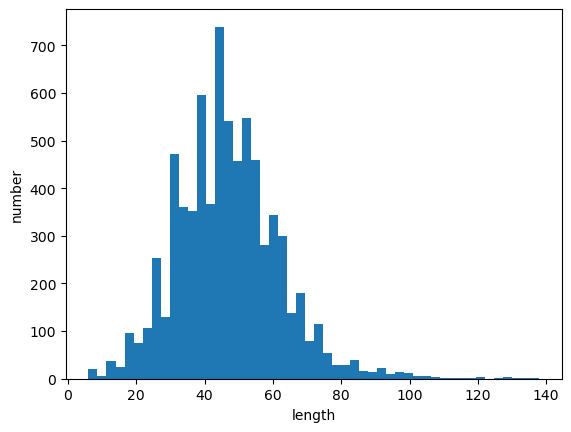

In [7]:
print('최대 길이 :',max(len(sent) for sent in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length')
plt.ylabel('number')
plt.show()

In [8]:
max_len = max(len(sent) for sent in X_train) # 최대 길이

In [9]:
# 학습 데이터의 시퀀스를 패딩하여 길이를 max_len으로 맞추기
# maxlen은 이전에 설정된 최대 길이
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)

# 테스트 데이터의 시퀀스를 패딩하여 길이를 max_len으로 맞추기
# 학습 데이터와 동일한 길이로 패딩하여 일관성 유지
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [10]:
# 하이퍼파라미터 설정
embedding_dim = 64  # 임베딩 벡터의 차원
hidden_units = 64   # LSTM 레이어의 은닉 유닛 수
num_classes = 1     # 출력 클래스의 수 (이진 분류인 경우 1)

# 모델 구성
model = Sequential()
# 임베딩 레이어: vocab_size의 단어들을 embedding_dim 차원의 벡터로 변환
model.add(Embedding(vocab_size, embedding_dim))
# Bidirectional LSTM 레이어: 양방향 LSTM을 사용하여 입력 시퀀스를 처리
model.add(Bidirectional(LSTM(embedding_dim)))
# Dense 레이어: 출력 클래스의 수에 따라 결과를 softmax 활성화 함수로 출력
model.add(Dense(num_classes, activation='sigmoid'))  # 이진 분류에서는 sigmoid 사용

# 콜백 정의
# 조기 종료: 검증 손실이 감소하지 않으면 학습을 조기에 종료
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# 모델 체크포인트: 검증 정확도가 가장 높은 모델을 저장
mc = ModelCheckpoint('best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 컴파일
# 손실 함수: 이진 분류이므로 binary_crossentropy 사용
# 옵티마이저: Adam 옵티마이저 사용
# 평가 메트릭: 정확도(acc) 사용
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5713 - loss: 0.6847
Epoch 1: val_accuracy improved from -inf to 0.56531, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.5714 - loss: 0.6846 - val_accuracy: 0.5653 - val_loss: 0.6809
Epoch 2/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6511 - loss: 0.6185
Epoch 2: val_accuracy improved from 0.56531 to 0.58027, saving model to best_model.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.6512 - loss: 0.6184 - val_accuracy: 0.5803 - val_loss: 0.7182
Epoch 3/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8050 - loss: 0.4239
Epoch 3: val_accuracy did not improve from 0.58027
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8049 - loss: 0.4240 - val_accuracy: 0.5639 - val_loss: 0.8112
Epoch 4/15
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8851 - loss: 0.2905
Epoch 4: val_accuracy did not improve from 0.58027
184/184 ━━━━━━━━━━━━

In [11]:
# 저장된 최적의 모델 로드
loaded_model = load_model('best_model.keras')

# 테스트 데이터로 모델 평가
# evaluate 함수는 손실과 메트릭(여기서는 정확도)을 반환
test_loss, test_acc = loaded_model.evaluate(X_test_encoded, y_test)

# 테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % test_acc) 

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5620 - loss: 0.7282

 테스트 정확도: 0.5713


-----